In [4]:
#!pip install gensim

In [5]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import re
import nltk
import os

from sqlalchemy import column

from gensim.models import Word2Vec
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import matplotlib.pyplot as plt

INFO - 03:36:24: generated new fontManager


Enter the file Path floop_data_15k.json


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
INFO - 03:40:37: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.03)', 'datetime': '2022-02-14T03:40:37.338948', 'gensim': '4.1.2', 'python': '3.7.10 (default, Jun  4 2021, 14:48:32) \n[GCC 7.5.0]', 'platform': 'Linux-4.14.256-197.484.amzn2.x86_64-x86_64-with-debian-10.6', 'event': 'created'}
INFO - 03:40:37: collecting all words and their counts
INFO - 03:40:37: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 03:40:37: PROGRESS: at sentence #10000, processed 80287 words, keeping 8478 word types
INFO - 03:40:37: collected 11409 word types from a corpus of 130228 raw words and 15617 sentences
INF

['what', 'is', 'this', 'word']
Time to build vocab: 0.0 mins


INFO - 03:40:37: worker thread finished; awaiting finish of 0 more threads
INFO - 03:40:37: EPOCH - 1 : training on 130228 raw words (20640 effective words) took 0.1s, 151032 effective words/s
INFO - 03:40:37: worker thread finished; awaiting finish of 0 more threads
INFO - 03:40:37: EPOCH - 2 : training on 130228 raw words (20915 effective words) took 0.1s, 186057 effective words/s
INFO - 03:40:37: worker thread finished; awaiting finish of 0 more threads
INFO - 03:40:37: EPOCH - 3 : training on 130228 raw words (20958 effective words) took 0.1s, 191491 effective words/s
INFO - 03:40:37: worker thread finished; awaiting finish of 0 more threads
INFO - 03:40:37: EPOCH - 4 : training on 130228 raw words (20847 effective words) took 0.1s, 192852 effective words/s
INFO - 03:40:38: worker thread finished; awaiting finish of 0 more threads
INFO - 03:40:38: EPOCH - 5 : training on 130228 raw words (20782 effective words) took 0.1s, 181662 effective words/s
INFO - 03:40:38: worker thread fini

Time to train the model: 0.06 mins


INFO - 03:40:42: NumExpr defaulting to 2 threads.


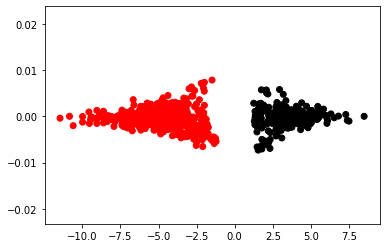

In [11]:

# nltk.download()
path = input("Enter the file Path")
df = pd.read_json (path)
df.to_csv (r'floop_data_15k.csv', index = None)

data = pd.read_csv("floop_data_15k.csv")

data.columns= ["Field1"]

data.shape


#To remove special characters and punctuation from our dataset
from string import punctuation

punctuations = punctuation

def solution(sentence):
    for p in punctuations:
        sentence = sentence.replace(p, '')
    return sentence

x = data["Field1"].apply(solution)
pattern = "[^a-zA-Z0-9]"
x_cleaned = [re.sub(pattern," ",text) for text in x]

x_lowered = [text.lower() for text in x_cleaned]
x_lowered

x_lowered[0]

nltk.download('punkt')
nltk.download('omw-1.4')

x_tokenized = [nltk.word_tokenize(text) for text in x_lowered]

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

x_lemmatized = [[lemma.lemmatize(word) for word in text] for text in x_tokenized]

print(x_lemmatized[0])





# For classification data whether good or bad.

w2v_model = Word2Vec(min_count=20,window=2,sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20,workers= 1 )

t = time()

w2v_model.build_vocab(x_lemmatized, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

t = time()

w2v_model.train(x_lemmatized, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

w2v_model.init_sims(replace=True)

w2v_model.save("word2vec11.model")

word_vectors = Word2Vec.load("word2vec11.model").wv
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]

model.cluster_centers_

def cast_vector(row):
    return np.array(list(map(lambda x: x.astype('double'), row)))

words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['vectorsmean'] = words.vectors.apply(lambda x: x.mean())
words['vectors_typed'] = words.vectors.apply(cast_vector)
words['cluster'] = words.vectors_typed.apply(lambda x: model.predict([np.array(x, dtype=np.double)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [1 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

words.head(10)

u_labels = np.unique(words['cluster'])

words['vectorsmean'] = words.vectors.apply(lambda x: x.mean())

words['vectorsmean'][0]

len(words["vectors"][1])

words.head(10)

# FOr plotting 

colors = {1: 'black', -1: 'Red'}
plt.scatter(words['sentiment_coeff'] , words['vectorsmean'] , c=words['cluster_value'].map(colors))

plt.show()

os.remove("floop_data_15k.csv")
os.remove("word2vec11.model")